In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
from toolz.curried import *
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas import DataFrame
from tqdm import tqdm

### Data Formatting

In [2]:
#constants 
carparkIdHeaderName = 'carparkId'
timestampHeaderName = 'timestamp'
dataTimestampHeaderName = 'dataTime'
capacityHeaderName = 'capacity'
occupancyHeaderName = 'occupancy'
availabilityHeaderName = 'availability'

In [3]:
#load data
data_fileName = 'data/Nottingham_dataset2.csv'
inputData = pd.read_csv(data_fileName)
condenseData = inputData.drop(columns=[dataTimestampHeaderName, capacityHeaderName, occupancyHeaderName])

In [4]:
inputData[carparkIdHeaderName].unique()

array(['210', '211', '212', 'Am2-1', 'Am3-2', 'BRDMSH', 'C11001',
       'C11002', 'C11004', 'C11005', 'C11006', 'C12002', 'FRSTPR',
       'PHNXPR', 'PRLMNT', 'QNSPR', 'RYLCT', 'SB1-1', 'VICNTH'],
      dtype=object)

In [5]:
#2. Format timestamp data
condenseData.timestamp = pd.to_datetime(condenseData.timestamp, dayfirst=True)
condenseData.timestamp = condenseData.timestamp.dt.floor("T")

In [6]:
#3. Format carpark id 
mapping = {carparkid: i for (i, carparkid) in enumerate(condenseData[carparkIdHeaderName].unique())}
condenseData["sid"] = condenseData[carparkIdHeaderName]
condenseData = condenseData.replace({"sid": mapping})

In [7]:
#4. Change column names, follow formatting in load_carpark_data_list 
condenseData.rename(columns={"timestamp": "tid"}, inplace=True)
condenseData = condenseData.groupby(["sid", "tid"]).agg(availability=("availability", "mean"))
sids = condenseData.reset_index().sid.unique()
tids = condenseData.reset_index().tid.unique()
tids = pd.date_range(start=tids.min(), end=tids.max(), freq="15min")
index = pd.MultiIndex.from_product([sids, tids], names=["sid", "tid"])
formattedData = condenseData.reindex(index)

In [8]:
#5. Follow formatting in carpark.ipynb 
carpark_data_o = formattedData.copy()
carpark_data_o.reset_index(inplace=True)
carpark_data_o.rename(columns={"tid": "date"}, inplace=True)

In [9]:
#function from util.py
def carpark_remove_outlier(carpark_data: DataFrame) -> DataFrame:
    
    def move_average(x, n):
        w = np.ones(n) / n
        x_f = np.convolve(x, w, mode="valid")
        x_b = np.convolve(x[-2*n+2:][::-1], w, mode="valid")[::-1]
        return np.concatenate([x_f, x_b])

    sids = carpark_data.reset_index().sid.unique()
    for sid in tqdm(sids):
        x = carpark_data.loc[sid].fillna(method="ffill").values.ravel()
        m = move_average(x, 5)
        idx, = np.where(np.abs(x - m) > 50)
        carpark_data.loc[sid].iloc[idx] = np.nan

    return carpark_data

In [10]:
carpark_data = carpark_remove_outlier(formattedData)
carpark_data = carpark_data.fillna(method="ffill")

100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 621.23it/s]


In [11]:
#function from util.py
def carpark_add_date(carpark_data: DataFrame) -> DataFrame:
    carpark_data = carpark_data.reset_index()
    carpark_data["date"] = carpark_data["tid"]
    carpark_data["tid"] = ((carpark_data["tid"] - carpark_data["tid"].min()) 
                            / np.timedelta64(15, "m")).astype(np.int32) #number of mins from start of data collection, in fractions of 10 min
    return carpark_data

In [12]:
#function from util.py
def carpark_remove_constant(carpark_data: DataFrame) -> DataFrame:
    nonconstant = carpark_data.groupby(["sid"]).apply(lambda x: x[availabilityHeaderName].std()) > 1.0
    nonconstant_sids = nonconstant[nonconstant].index
    return carpark_data[carpark_data.sid.isin(nonconstant_sids)]

In [13]:
carpark_data2 = carpark_add_date(carpark_data)
carpark_data2 = carpark_remove_constant(carpark_data2)
carpark_data2["min"] = (carpark_data2.tid % 96).astype(str) #remainder of spare minutes from start time in the day divide by 5

In [14]:
carpark_data2['Weekday']=carpark_data2['date'].dt.dayofweek.astype(str)

In [15]:
#check for any negative values 
carpark_data2.describe()

,sid,tid,availability
count,205732.000000,205732.000000,205732.000000
mean,9.000000,5413.500000,383.057434
std,5.477239,3125.781941,310.524039
min,0.000000,0.000000,0.000000
25%,4.000000,2706.750000,128.000000
50%,9.000000,5413.500000,342.000000
75%,14.000000,8120.250000,472.000000
max,18.000000,10827.000000,1139.000000


In [16]:
#check for any nan or null values 
carpark_data2.isnull().values.any()

False

In [17]:
carpark_data2[carpark_data2.sid==0].describe()

,sid,tid,availability
count,10828.0,10828.000000,10828.000000
mean,0.0,5413.500000,308.027521
std,0.0,3125.918692,158.536364
min,0.0,0.000000,0.000000
25%,0.0,2706.750000,203.000000
50%,0.0,5413.500000,352.000000
75%,0.0,8120.250000,454.000000
max,0.0,10827.000000,472.000000


### Model Training 

In [18]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch
from torch.utils.data import DataLoader

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE
from customRNNDataloader import subset_sampler

In [19]:
context_length = 12*4 #maximum history length 
prediction_length = 2*4 #prediction length

training_cutoff = 89*24*4
validation_cutoff = 100*24*4
test_cutoff = 112*24*4

In [20]:
training = TimeSeriesDataSet(
    carpark_data2[lambda x: x.tid <= training_cutoff], #data data frame
    time_idx="tid", #integer column denoting time index
    group_ids=["sid"], #list of column names identifying a time series
    target=availabilityHeaderName,
    time_varying_unknown_reals=[availabilityHeaderName], #change with time and not known in the future 
    max_encoder_length=context_length, #maximum history length
    max_prediction_length=prediction_length,
    time_varying_known_categoricals=["min", "Weekday"], #categorical variables that change with time and known in the future 
)

validation = TimeSeriesDataSet.from_dataset(
    training,    #dataset to copy parameters                                      
    carpark_data2[lambda x: x.tid <= validation_cutoff], #data 
    min_prediction_idx=training_cutoff + 1 #minimum time_idx from where to start predictions
)

test = TimeSeriesDataSet.from_dataset(
    training, 
    carpark_data2,
    min_prediction_idx=validation_cutoff + 1
)

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:618: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


In [22]:
#save trainnning objject 
torch.save(training,  'Nottingham_training_dataset.pt')

In [23]:
#save test object
torch.save(test, 'Nottingham_test_dataset.pt')

In [21]:
train_sampler = subset_sampler(training, 0.5, random=True)
val_sampler = subset_sampler(validation, 0.05)
test_sampler = subset_sampler(test, 0.05)

In [22]:
batch_size = 200
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, 
                                          num_workers=8)                                          
val_dataloader = validation.to_dataloader(batch_size=500, num_workers=8,
                                          shuffle=False, sampler=val_sampler)                                          
test_dataloader = test.to_dataloader(batch_size=500, num_workers=8,
                                     shuffle=False, sampler=test_sampler)

In [23]:
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

806
1
2


In [24]:
actuals = torch.cat([y[0] for _, y in iter(test_dataloader)])
mask = actuals > 1.0

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=t

In [25]:
#Implementation of LSTM model 

from models import RNN

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, 
                                    patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=50,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=500
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [26]:
rnn = RNN.from_dataset(
    training,
    embedding_sizes={"min": (96, 91), "Weekday": (7, 20)}, #dictionary mapping (string) indices to tuple of number of categorical classes and embedding size
    # embedding_sizes={"min": (1440 // 5, 91)},
    cell_type="GRU",
    hidden_size=50,
    learning_rate=1e-3,
    log_interval=50,
    log_val_interval=50,
    weight_decay=1e-3,
)

In [27]:
print("rnn.lagged_target_positions")
print(rnn.lagged_target_positions)

rnn.lagged_target_positions
{}


In [31]:
trainer.fit(
    rnn,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 8.9 K 
3 | rnn              | GRU            | 39.9 K
4 | output_projector | Linear         | 51    
----------------------------------------------------
48.8 K    Trainable params
0         Non-trainable params
48.8 K    Total params
0.195     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)


Training: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Validating: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  war

Validating: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  war

Validating: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  war

Validating: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  war

Validating: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  war

Validating: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  war

Validating: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  war

Validating: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  war

Validating: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  war

Validating: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  war

Validating: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  war

Validating: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  war

Validating: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  war

Validating: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  war

Validating: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  war

Validating: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  war

Validating: 0it [00:00, ?it/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)


1

In [32]:
print("rnn.hparams")
print(rnn.hparams)

rnn.hparams
"categorical_groups":                {}
"cell_type":                         GRU
"dropout":                           0.1
"embedding_labels":                  {'min': {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '43': 38, '44': 39, '45': 40, '46': 41, '47': 42, '48': 43, '49': 44, '5': 45, '50': 46, '51': 47, '52': 48, '53': 49, '54': 50, '55': 51, '56': 52, '57': 53, '58': 54, '59': 55, '6': 56, '60': 57, '61': 58, '62': 59, '63': 60, '64': 61, '65': 62, '66': 63, '67': 64, '68': 65, '69': 66, '7': 67, '70': 68, '71': 69, '72': 70, '73': 71, '74': 72, '75': 73, '76': 74, '77': 75, '78': 76, '79': 77, '8': 78, '80': 79, '81': 80, '82': 81, '83': 82, '84': 83,

In [33]:
device = torch.device("cuda:0")
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = RNN.load_from_checkpoint(best_model_path).to(device)
print("Print b0.est model path: ", best_model_path)
print("Print best model device: ", best_model.device)

Print b0.est model path:  /home/qishuai/Documents/Zhi-Qing/carpark_prediction-main_nottingham/lightning_logs/version_3/checkpoints/epoch=6-step=3499.ckpt
Print best model device:  cuda:0


In [29]:
predictions = best_model.predict(test_dataloader, batch_size=500, show_progress_bar=True)
print("Prediction shape: ", predictions.shape)

#MAE

abs_error = torch.abs(predictions - actuals)
print("Absolute error shape: ", abs_error.shape)

print("Print torch.mean(abs_error * mask): ", torch.mean(abs_error * mask))
abs_error_steps = torch.mean(abs_error * mask, dim=0)
print("Print abs_error_steps.shape: ", abs_error_steps.shape)

#MAPE

mape = abs_error / (actuals + 1e-5)
print("Print torch.mean(mape * mask): ", torch.mean(mape * mask))
mape_steps = torch.mean(mape * mask, dim=0)

#rmse
squared_error = torch.square(predictions - actuals)
mse_steps = torch.mean(squared_error * mask, dim=0)
rmse_steps = torch.sqrt(mse_steps)

Predict:   0%|          | 0/2 [00:00<?, ? batches/s]

/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/home/qishuai/anaconda3/envs/glasgow/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1649: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=t

Prediction shape:  torch.Size([1000, 8])
Absolute error shape:  torch.Size([1000, 8])
Print torch.mean(abs_error * mask):  tensor(24.6324)
Print abs_error_steps.shape:  torch.Size([8])
Print torch.mean(mape * mask):  tensor(0.2460)


In [30]:
abs_error

tensor([[5.2355e+00, 1.3560e+02, 1.6827e+02,  ..., 1.8136e+02, 1.9444e+02,
         1.9429e+02],
        [5.8679e+00, 1.5777e+01, 1.5302e+01,  ..., 4.2354e+01, 4.7507e+01,
         5.1247e+01],
        [5.3678e-01, 6.4141e+00, 3.5161e+00,  ..., 5.2085e+00, 3.2374e+00,
         3.4843e-02],
        ...,
        [1.3261e+01, 1.2359e+01, 1.8716e+01,  ..., 1.8911e+01, 2.5290e-01,
         8.9031e+01],
        [5.7233e-01, 2.4042e+00, 2.7809e+00,  ..., 3.9427e+00, 4.1863e+00,
         3.8040e+00],
        [1.4243e+00, 2.2601e-01, 2.1927e+00,  ..., 1.2754e+01, 2.2406e+01,
         3.5935e+01]])

In [31]:
squared_error

tensor([[2.7411e+01, 1.8387e+04, 2.8314e+04,  ..., 3.2890e+04, 3.7808e+04,
         3.7749e+04],
        [3.4432e+01, 2.4892e+02, 2.3415e+02,  ..., 1.7938e+03, 2.2569e+03,
         2.6262e+03],
        [2.8813e-01, 4.1141e+01, 1.2363e+01,  ..., 2.7128e+01, 1.0481e+01,
         1.2141e-03],
        ...,
        [1.7585e+02, 1.5275e+02, 3.5027e+02,  ..., 3.5762e+02, 6.3958e-02,
         7.9265e+03],
        [3.2756e-01, 5.7801e+00, 7.7333e+00,  ..., 1.5545e+01, 1.7525e+01,
         1.4471e+01],
        [2.0287e+00, 5.1082e-02, 4.8077e+00,  ..., 1.6267e+02, 5.0204e+02,
         1.2913e+03]])

In [32]:
print(mse_steps)

tensor([  403.6001,  2343.6521,  4134.0122,  7105.0322,  8300.3379, 11627.1943,
        13643.8281, 14995.0879])


In [33]:
mse_steps.shape

torch.Size([8])

In [34]:
print(rmse_steps)

tensor([ 20.0898,  48.4113,  64.2963,  84.2914,  91.1062, 107.8295, 116.8068,
        122.4544])


In [35]:
abs_error_steps

tensor([ 5.7336, 10.4434, 15.9171, 22.0440, 26.0447, 34.0895, 39.2317, 43.5553])

Text(0, 0.5, 'MAE')

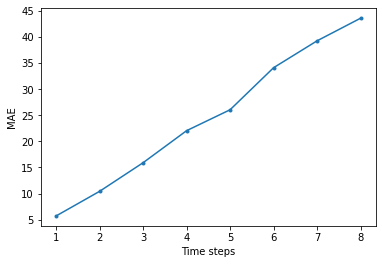

In [36]:
plt.plot(torch.arange(1, len(abs_error_steps)+1), abs_error_steps, ".-")
plt.xlabel("Time steps")
plt.ylabel("MAE")
#plt.xlim([1, 120])
#plt.xticks([1, 20, 40, 60, 80, 100, 120]);

In [37]:
# 15 min
abs_error_steps[0]

tensor(5.7336)

In [38]:
# 30 min
abs_error_steps[1]

tensor(10.4434)

In [39]:
# 45 min
abs_error_steps[2]

tensor(15.9171)

In [40]:
# 60 min
abs_error_steps[3]

tensor(22.0440)

Text(0, 0.5, 'MAPE')

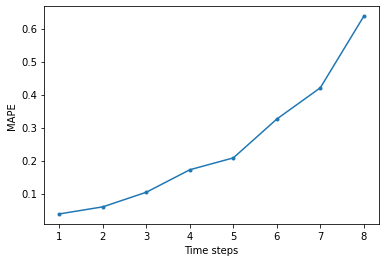

In [41]:
plt.plot(torch.arange(1, len(mape_steps)+1), mape_steps, ".-")
plt.xlabel("Time steps")
plt.ylabel("MAPE")
#plt.xlim([1, 120])
#plt.xticks([1, 20, 40, 60, 80, 100, 120]);

In [42]:
#15 min
mape_steps[0]

tensor(0.0385)

In [43]:
#30 min
mape_steps[1]

tensor(0.0600)

In [44]:
#45 min
mape_steps[2]

tensor(0.1043)

In [45]:
#60 min
mape_steps[3]

tensor(0.1724)

Text(0, 0.5, 'RMSE')

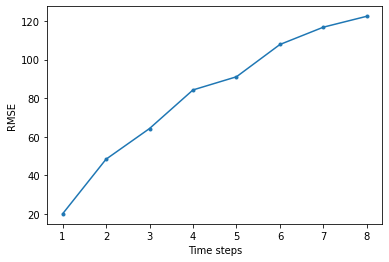

In [46]:
plt.plot(torch.arange(1, len(rmse_steps)+1), rmse_steps, ".-")
plt.xlabel("Time steps")
plt.ylabel("RMSE")
#plt.xlim([1, 120])
#plt.xticks([1, 20, 40, 60, 80, 100, 120]);

In [47]:
#15 min
rmse_steps[0]

tensor(20.0898)

In [48]:
#30 min
rmse_steps[1]

tensor(48.4113)

In [50]:
#45 min
rmse_steps[2]

tensor(64.2963)

In [51]:
#60 min
rmse_steps[3]

tensor(84.2914)

In [52]:
print("30 min section")
n = abs_error.shape[0]
step = 2 # 30 mins later

30 min section


μ = 10.4434, σ = 47.2951, max = 993.2935


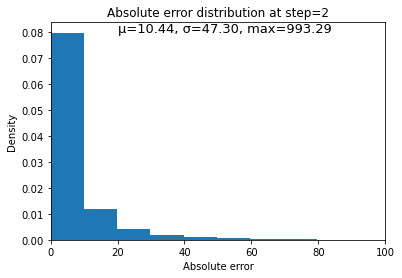

In [53]:
abs_error_step = abs_error[:, step-1] * mask[:, step-1]

σ, μ = torch.std_mean(abs_error_step)
print(f"μ = {μ:.4f}, σ = {σ:.4f}, max = {abs_error_step.max():.4f}")
xs = abs_error_step[torch.randperm(n)[:1000]].cpu().numpy()

n = len(abs_error_step)
plt.hist(xs, 100, density=True)
plt.xlim(0, 100)
plt.xlabel("Absolute error")
plt.ylabel("Density")
plt.text(20, 0.08, f"μ={μ:.2f}, σ={σ:.2f}, max={abs_error_step.max():.2f}",
         fontsize=13)
plt.title(f"Absolute error distribution at step={step}");